In [6]:
import os
current_directory = os.getcwd()
print(f"Current Working Directory: {current_directory}")

from Tusc5ImageUtils import *
import numpy as np
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage import exposure
mpl.rcParams['figure.dpi'] = 300
from cellpose import utils, io, plot, models, denoise
from scipy.ndimage import binary_erosion, binary_fill_holes, center_of_mass
import subprocess
import pandas as pd
import nd2
from skimage.measure import regionprops

Current Working Directory: d:\Lab Analysis PC\ImageAnalysis


In [41]:
### Directory Configuration ###

parent_directory = os.path.dirname(current_directory) # Parent directory
test_stacks_directory = os.path.join(parent_directory, '080524_081824_combined')

model_path_dapi = os.path.join(parent_directory, 'ImageAnalysis/cellpose_models/T5_DAPI_V4')
img_path = os.path.join(test_stacks_directory, '3420L_GLUT1_647_WGA_594_0002.nd2')

In [42]:
### Image Insertion ###
f = nd2.ND2File(img_path)
image = to_8bit(f.asarray())

DAPI_stack = image[:,0,:,:].copy()
eGFP_stack = image[:,1,:,:].copy()
WGA_stack = image[:,2,:,:].copy()

mp_DAPI = max_proj(DAPI_stack)
model = models.CellposeModel(pretrained_model=model_path_dapi)
DAPI_masks, flows, styles = model.eval(mp_DAPI, diameter=None, channels=[0,0])

C:\Users\Luis\AppData\Local\Temp\ipykernel_4276\1405454312.py:2: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  f = nd2.ND2File(img_path)


In [43]:
# 1) Finding coordinates of cells
coords_3d = nuclei_centers_of_mass(DAPI_stack, DAPI_masks)

# 2) Removing local outliers from mask
filtered_coords_3d, filtered_idxs = remove_outliers_local(coords_3d)
DAPI_masks = extract_masks(DAPI_masks, filtered_idxs)


# Removing local outliers

(-0.5, 1023.5, 1023.5, -0.5)

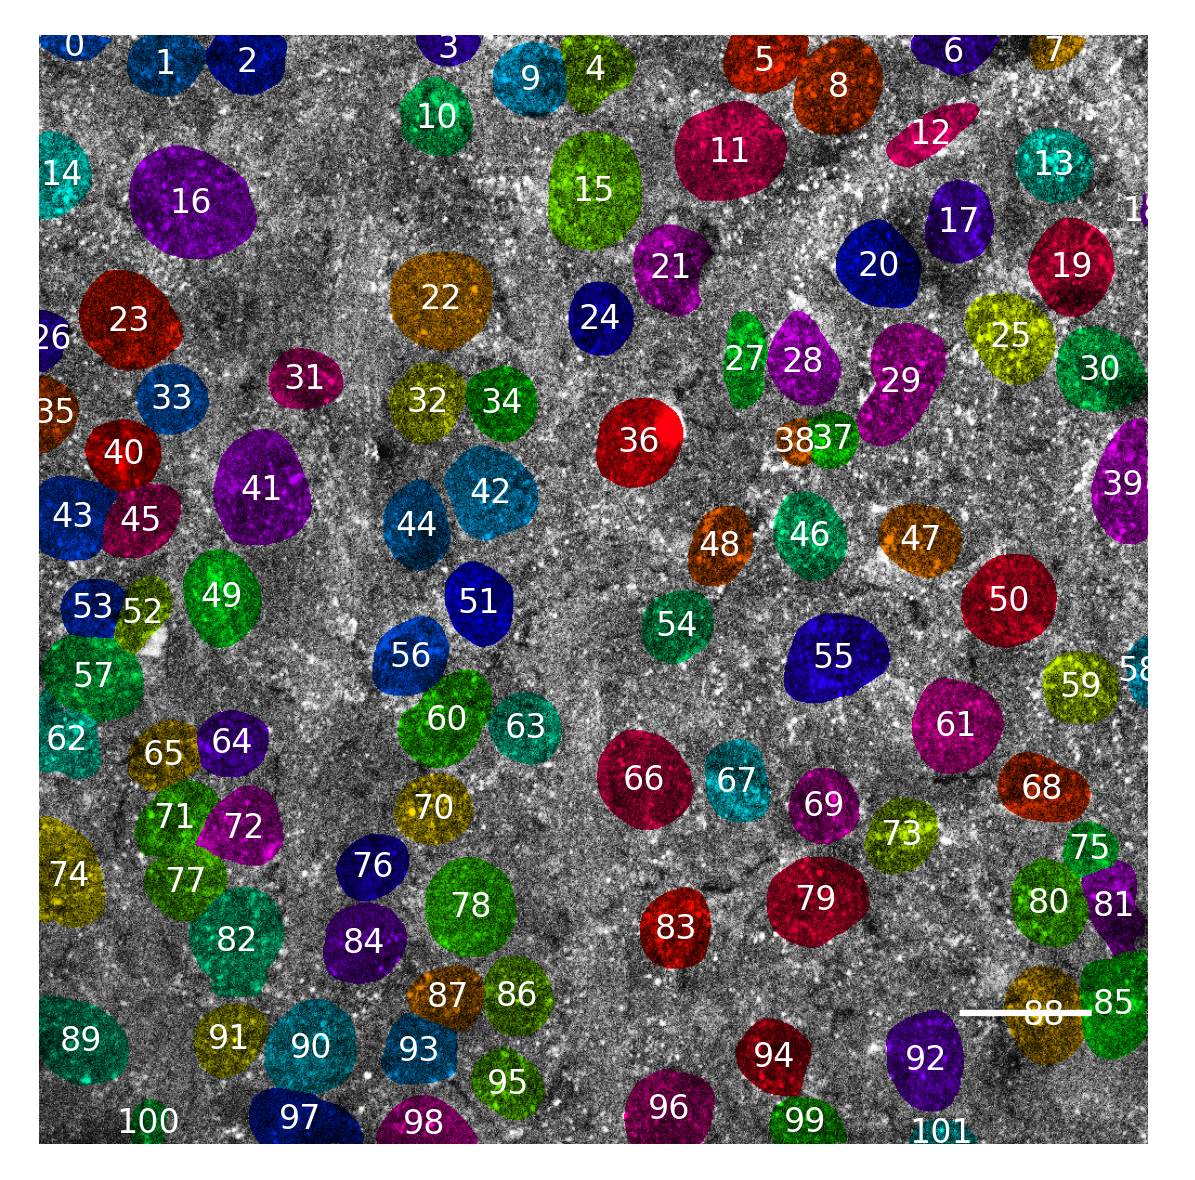

In [44]:
nuclei_zs = nuclei_slices(DAPI_stack, DAPI_masks)
z_intensities = np.sum(WGA_stack, axis=(1, 2))
ILM_layer = int(np.argmax(z_intensities))
nuclei_layer = np.sum(nuclei_zs) // len(nuclei_zs)
vein_axon_layer = int((ILM_layer + nuclei_layer) / 2)

overlay = plot.mask_overlay(WGA_stack[ILM_layer, :, :], DAPI_masks)
overlay = auto_brightness_contrast(overlay)
overlay = add_scale_bar(overlay, .123, 15, 850, 900)

plt.imshow(overlay)
plot_maskids(get_nuclei_position(DAPI_masks), text_color= 'white', font_size= 8)
plt.axis('off')

In [7]:
import tkinter as tk

class NumberInputApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Fast Number Input")
        
        self.input_var = tk.StringVar()
        self.input_list = []

        self.create_widgets()
        self.bind_keys()

    def create_widgets(self):
        # Create an Entry widget to display the input
        self.entry = tk.Entry(self.root, textvariable=self.input_var, font=('Helvetica', 24), justify='center')
        self.entry.grid(row=0, column=0, columnspan=3)

        # Create number buttons
        self.buttons = []
        for i in range(1, 10):
            button = tk.Button(self.root, text=str(i), font=('Helvetica', 24), command=lambda i=i: self.on_button_click(i))
            self.buttons.append(button)

        # Arrange buttons in a grid
        for i in range(1, 10):
            self.buttons[i-1].grid(row=(i-1)//3 + 1, column=(i-1)%3)

        # Create Clear and Submit buttons
        self.clear_button = tk.Button(self.root, text="Clear", font=('Helvetica', 24), command=self.clear_input)
        self.clear_button.grid(row=4, column=0)

        self.submit_button = tk.Button(self.root, text="Submit", font=('Helvetica', 24), command=self.submit_input)
        self.submit_button.grid(row=4, column=2)

    def bind_keys(self):
        for i in range(1, 10):
            self.root.bind(str(i), self.on_key_press)
        self.root.bind('<Return>', self.submit_input)
        self.root.bind('<BackSpace>', self.on_backspace_press)

    def on_button_click(self, number):
        current_value = self.input_var.get()
        self.input_var.set(current_value + str(number))

    def on_key_press(self, event):
        current_value = self.input_var.get()
        self.input_var.set(current_value + event.char)

    def on_backspace_press(self, event):
        current_value = self.input_var.get()
        self.input_var.set(current_value[:-1])

    def clear_input(self):
        self.input_var.set("")

    def submit_input(self, event=None):
        input_value = self.input_var.get()
        if input_value:
            self.input_list.append(int(input_value))
            print("User input:", input_value)
            self.clear_input()

# Create the main window
root = tk.Tk()
app = NumberInputApp(root)

# Run the main event loop
root.mainloop()

# Print the collected inputs after the window is closed
print("Collected inputs:", app.input_list)

Collected inputs: []


In [8]:
# Plots ripped cells
nuclei_zs = nuclei_slices(DAPI_stack, DAPI_masks)
z_intensities = np.sum(WGA_stack, axis=(1, 2))
ILM_layer = int(np.argmax(z_intensities))
nuclei_layer = np.sum(nuclei_zs) // len(nuclei_zs)
vein_axon_layer = int((ILM_layer + nuclei_layer) / 2)

overlay = plot.mask_overlay(WGA_stack[ILM_layer, :, :], DAPI_masks)
fig, ax = plt.subplots()
ax.imshow(overlay)
plot_maskids(get_nuclei_position(DAPI_masks), text_color='white', font_size=8)
ax.axis('off')


# Input window
root = tk.Tk()
app = NumberInputApp(root)
root.mainloop()
nd2_file = 'hello'

cells_in_rip = {nd2_file: app.input_list}
# Close the figure without displaying it
plt.close(fig)

cells_in_rip

{'hello': []}

In [3]:
import tkinter as tk
from tkinter import ttk
from PIL import Image, ImageTk
import numpy as np
import matplotlib.pyplot as plt
from cellpose import plot, models

class NumberInputApp:
    def __init__(self, root, overlay_image):
        self.root = root
        self.root.title("Fast Number Input")
        
        self.input_var = tk.StringVar()
        self.input_list = []

        self.overlay_image = overlay_image
        self.zoom_factor = 1.0  # Initialize zoom factor
        self.offset_x = 0
        self.offset_y = 0
        self.drag_start_x = 0
        self.drag_start_y = 0

        self.create_widgets()
        self.bind_keys()
        self.bind_zoom()
        self.bind_drag()

    def create_widgets(self):
        # Create an Entry widget to display the input
        self.entry = tk.Entry(self.root, textvariable=self.input_var, font=('Helvetica', 24), justify='center')
        self.entry.grid(row=0, column=0, columnspan=3)

        # Create number buttons
        self.buttons = []
        for i in range(1, 9):
            button = tk.Button(self.root, text=str(i), font=('Helvetica', 24), command=lambda i=i: self.on_button_click(i))
            self.buttons.append(button)

        # Arrange buttons in a grid
        for i in range(1, 9):
            self.buttons[i-1].grid(row=(i-1)//3 + 1, column=(i-1)%3)

        # Create Clear and Submit buttons
        self.clear_button = tk.Button(self.root, text="Clear", font=('Helvetica', 24), command=self.clear_input)
        self.clear_button.grid(row=4, column=0)

        self.submit_button = tk.Button(self.root, text="Submit", font=('Helvetica', 24), command=self.submit_input)
        self.submit_button.grid(row=4, column=2)

        # Create a Label to display the image
        self.image_label = tk.Label(self.root)
        self.image_label.grid(row=5, column=0, columnspan=3)
        self.display_image()

    def bind_keys(self):
        for i in range(1, 9):
            self.root.bind(str(i), self.on_key_press)
        self.root.bind('<Return>', self.submit_input)
        self.root.bind('<BackSpace>', self.on_backspace_press)

    def bind_zoom(self):
        self.root.bind("<MouseWheel>", self.on_mouse_wheel)

    def bind_drag(self):
        self.image_label.bind("<ButtonPress-1>", self.on_button_press)
        self.image_label.bind("<B1-Motion>", self.on_mouse_drag)
        self.image_label.bind("<ButtonRelease-1>", self.on_button_release)

    def on_button_click(self, number):
        current_value = self.input_var.get()
        self.input_var.set(current_value + str(number))

    def on_key_press(self, event):
        current_value = self.input_var.get()
        self.input_var.set(current_value + event.char)

    def on_backspace_press(self, event):
        current_value = self.input_var.get()
        self.input_var.set(current_value[:-1])

    def clear_input(self):
        self.input_var.set("")

    def submit_input(self, event=None):
        input_value = self.input_var.get()
        if input_value:
            self.input_list.append(int(input_value))
            print("User input:", input_value)
            self.clear_input()

    def display_image(self):
        image = Image.fromarray(self.overlay_image)
        new_size = (int(500 * self.zoom_factor), int(500 * self.zoom_factor))
        image = image.resize(new_size, Image.Resampling.LANCZOS)
        photo = ImageTk.PhotoImage(image)

        # Adjust the image position based on the offset
        self.image_label.config(image=photo)
        self.image_label.image = photo
        self.image_label.place(x=self.offset_x, y=self.offset_y)

    def on_mouse_wheel(self, event):
        if event.delta > 0:
            self.zoom_factor *= 1.1  # Zoom in
        elif event.delta < 0:
            self.zoom_factor *= 0.9  # Zoom out
        self.display_image()

    def on_button_press(self, event):
        self.drag_start_x = event.x
        self.drag_start_y = event.y

    def on_mouse_drag(self, event):
        delta_x = event.x - self.drag_start_x
        delta_y = event.y - self.drag_start_y
        self.offset_x += delta_x
        self.offset_y += delta_y
        self.drag_start_x = event.x
        self.drag_start_y = event.y
        self.display_image()

    def on_button_release(self, event):
        pass

def rip_identifier(nd2_file, wga_stack, dapi_masks):
    def run_app(overlay_image):
        root = tk.Tk()
        app = NumberInputApp(root, overlay_image)
        root.mainloop()
        return app.input_list

    # Plots ripped cells
    z_intensities = np.sum(wga_stack, axis=(1, 2))
    ILM_layer = int(np.argmax(z_intensities))

    overlay = plot.mask_overlay(wga_stack[ILM_layer, :, :], dapi_masks)
    overlay_image = np.array(overlay)

    # Run the Tkinter input window
    cells_in_rip = {nd2_file: run_app(overlay_image)}

    return cells_in_rip

# Example usage with dummy data
if __name__ == "__main__":
    # Replace these with actual data
    nd2_file = 'example.nd2'
    wga_stack = np.random.randint(0, 255, (10, 256, 256), dtype=np.uint8)
    dapi_masks = np.random.randint(0, 2, (256, 256), dtype=np.uint8)
rip_identifier(nd2_file, wga_stack, dapi_masks)